In [1]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.

# Chapter 8: Pytorchによる深層学習
様々な領域においてビッグデータが整備されてきている昨今，入出力の非線形な依存関係を捉え，複雑なモデルを（ある意味勝手に）学習してくれる深層学習は分類，回帰などの様々なタスクに対して有効なツールであるといえます．<br>
Pytorchは今後少なくとも後2~3年くらいは有力なライブラリなのではと思うので学んでいきましょう．<br>
基本的なライブラリは[Chapter6](./Chapter6.ipynb)を終えた時点でもう揃っていると思います．<br>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print(torch.__version__)

2.0.1+cpu


今回はMNISTとよばれる手書き数字データセットの分類に深層学習を用いてみることにしましょう.
こちらは有名なデータセットであり，Pytorchのライブラリ内に元から用意されているので`wget`などを用いて用意する必要はありません（もちろん内部的には行われています）<br>
以下はデータセット準備のコードになります．\
**なお次に転移学習を行う都合上，データセットから「０」と「１」を削除しています**

In [3]:
#データの前処理を行うクラスインスタンス
transform = transforms.Compose(
    [transforms.Resize((16, 16)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

batch_size = 100

#使用するtrainデータセット
trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
mask = ~((trainset.targets == 1) | (trainset.targets == 0))
trainset.data = trainset.data[mask]
trainset.targets = trainset.targets[mask]
trainset.targets = trainset.targets - 2
#データ分割
trainset, _ = torch.utils.data.random_split(trainset, [10000, len(trainset)-10000])
print(len(trainset))

#trainデータをbatchごとに逐次的に取り出してくれるクラスインスタンス
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=batch_size,
                                            shuffle=True)

#使用するtestデータセット（以下略）
testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
mask = ~((testset.targets == 1) | (testset.targets == 0))
testset.data = testset.data[mask]
testset.targets = testset.targets[mask]
testset.targets = testset.targets - 2

testset, _ = torch.utils.data.random_split(testset, [1000, len(testset)-1000])
print(len(testset))

testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=batch_size,
                                            shuffle=False)

10000
1000


In [4]:
import torch.nn.functional as F
#モデルの定義
class NeuralNet(torch.nn.Module):
    def __init__(self, n_input=256, n_hidden=16, n_output=8):
        super(NeuralNet, self).__init__()
        self.n_input = n_input
        
        #一層目と二層目の重み行列の定義
        self.l1 = torch.nn.Linear(n_input,  n_hidden, bias = True)
        self.l2 = torch.nn.Linear(n_hidden, n_hidden, bias = True)
        self.l3 = torch.nn.Linear(n_hidden, n_output, bias = True)
        
    def forward(self, x):
        #画像データ(２次元）を1次元に落とす
        x = x.view(-1, self.n_input)
        
        #一層目の重み行列をかける
        a1 = self.l1(x)
        
        #活性化関数に通す
        h1 = F.sigmoid(a1)
        #h1 = F.relu(a1)
        
        #二層目の重み行列をかける
        a2 = self.l2(h1)
        
        #活性化関数に通す
        h2 = F.sigmoid(a2)
        #h2 = F.relu(a2)
        
        #三層目の重み行列をかける
        a3 = self.l3(h2)
        
        return a3

In [5]:
#モデルインスタンスの作成
model = NeuralNet()

#loss関数の設定
criterion = torch.nn.CrossEntropyLoss()

#最適化手法の設定
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

true: 2, predict: 4
true: 7, predict: 4
true: 5, predict: 4
true: 2, predict: 4
true: 4, predict: 4
true: 6, predict: 4
true: 3, predict: 4
true: 9, predict: 4
true: 8, predict: 4
true: 5, predict: 4


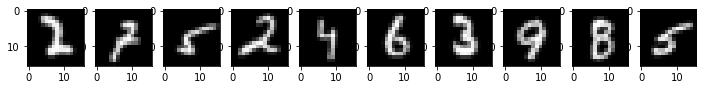

In [6]:
#モデルの予想を可視化する関数の作成
def prediction(model, num=10):
    with torch.no_grad():
        img, t = iter(testloader).__next__()
        t_pred = model(img)
        fig = plt.figure(figsize=(12,4))
        ax = []
        for i in range(num):
            print(f'true: {t[i]+2}, predict: {np.argmax(t_pred[i])+2}')
            ax.append(fig.add_subplot(1, num, i+1))
            ax[i].imshow(img[i, 0], cmap='gray')
        plt.show()

#学習前でどのような予測をするのかを表示
prediction(model)

学習前では正確に予測できていないことを確認してください．<br>
それではモデルの予測精度を上げるために学習を行いましょう.

In [7]:
#学習
epochs = 30
train_loss = []
test_loss  = []
test_acc = []
train_num_batchs = np.ceil(len(trainset) / float(batch_size))
test_num_batchs  = np.ceil(len(testset)  / float(batch_size))
for epoch in range(epochs):
    loss_sum = 0
    #trainloaderからbatchごとのデータを取り出し
    for X, t in trainloader:
        t_pred = model(X)
        loss = criterion(t_pred, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach()
    loss_sum /= train_num_batchs
    train_loss.append(float(loss_sum))
    #今回はテストデータに対する予測誤差や精度が各epochでどのように変化したのかを確かめます．
    with torch.no_grad():
        loss_sum = 0
        correct = 0
        for X, t in testloader:
            t_pred = model(X)
            loss = criterion(t_pred, t)
            loss_sum += loss.detach()
            pred = t_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(t.view_as(pred)).sum().item()
        loss_sum /= test_num_batchs
        test_loss.append(float(loss_sum))
        test_acc.append(correct/len(testloader))
    print(f'\repoch: {epoch+1}/{epochs}, train loss: {train_loss[epoch]}, test loss: {test_loss[epoch]}, test_acc: {correct}/{len(testset)}.....', end='')

epoch: 30/30, train loss: 0.4538841247558594, test loss: 0.4654427170753479, test_acc: 872/1000.....

[]

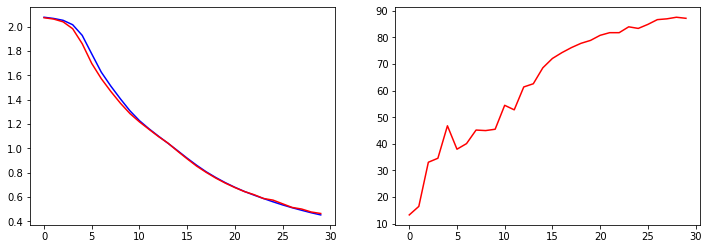

In [8]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_loss, c='b', label='train')
ax1.plot(test_loss,  c='r', label='test')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(test_acc, c='r', label='test')
plt.plot()

true: 2, predict: 2
true: 7, predict: 7
true: 5, predict: 8
true: 2, predict: 2
true: 4, predict: 4
true: 6, predict: 6
true: 3, predict: 2
true: 9, predict: 9
true: 8, predict: 8
true: 5, predict: 5


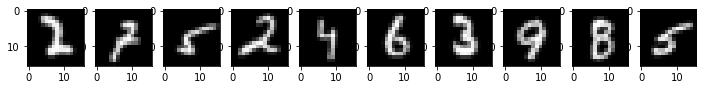

In [9]:
prediction(model)

In [10]:
torch.save(model.state_dict(), "params/model_state_dict.pth")

まぁまぁの精度で手書き文字の分類ができるようになったと思います．<br>
深層学習の基礎となるところなのでしっかりコードを理解するようにしましょう！